# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [204]:
# import libraries
import re
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sqlalchemy import create_engine
from nltk.corpus import stopwords
import pickle
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tonyl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tonyl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tonyl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [173]:
# load data from database
def load_data():
    '''
    '''
    engine = create_engine('sqlite:///DisasterResponse.db')
    conn = engine.connect()
    df = pd.read_sql('SELECT * FROM DisasterResponse', con = conn)
    X = df['message']
    y = df.drop(['id','message','original'], axis=1)
    return X, y

In [214]:
engine = create_engine('sqlite:///data/DisasterResponse.db')
conn = engine.connect()
df = pd.read_sql('SELECT * FROM DisasterResponse', con = conn)
X = df['message']
y = df.drop(['id','message','original', 'genre'], axis=1)

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [216]:
for col in y:
    y[col] = pd.to_numeric(y[col])

<AxesSubplot:>

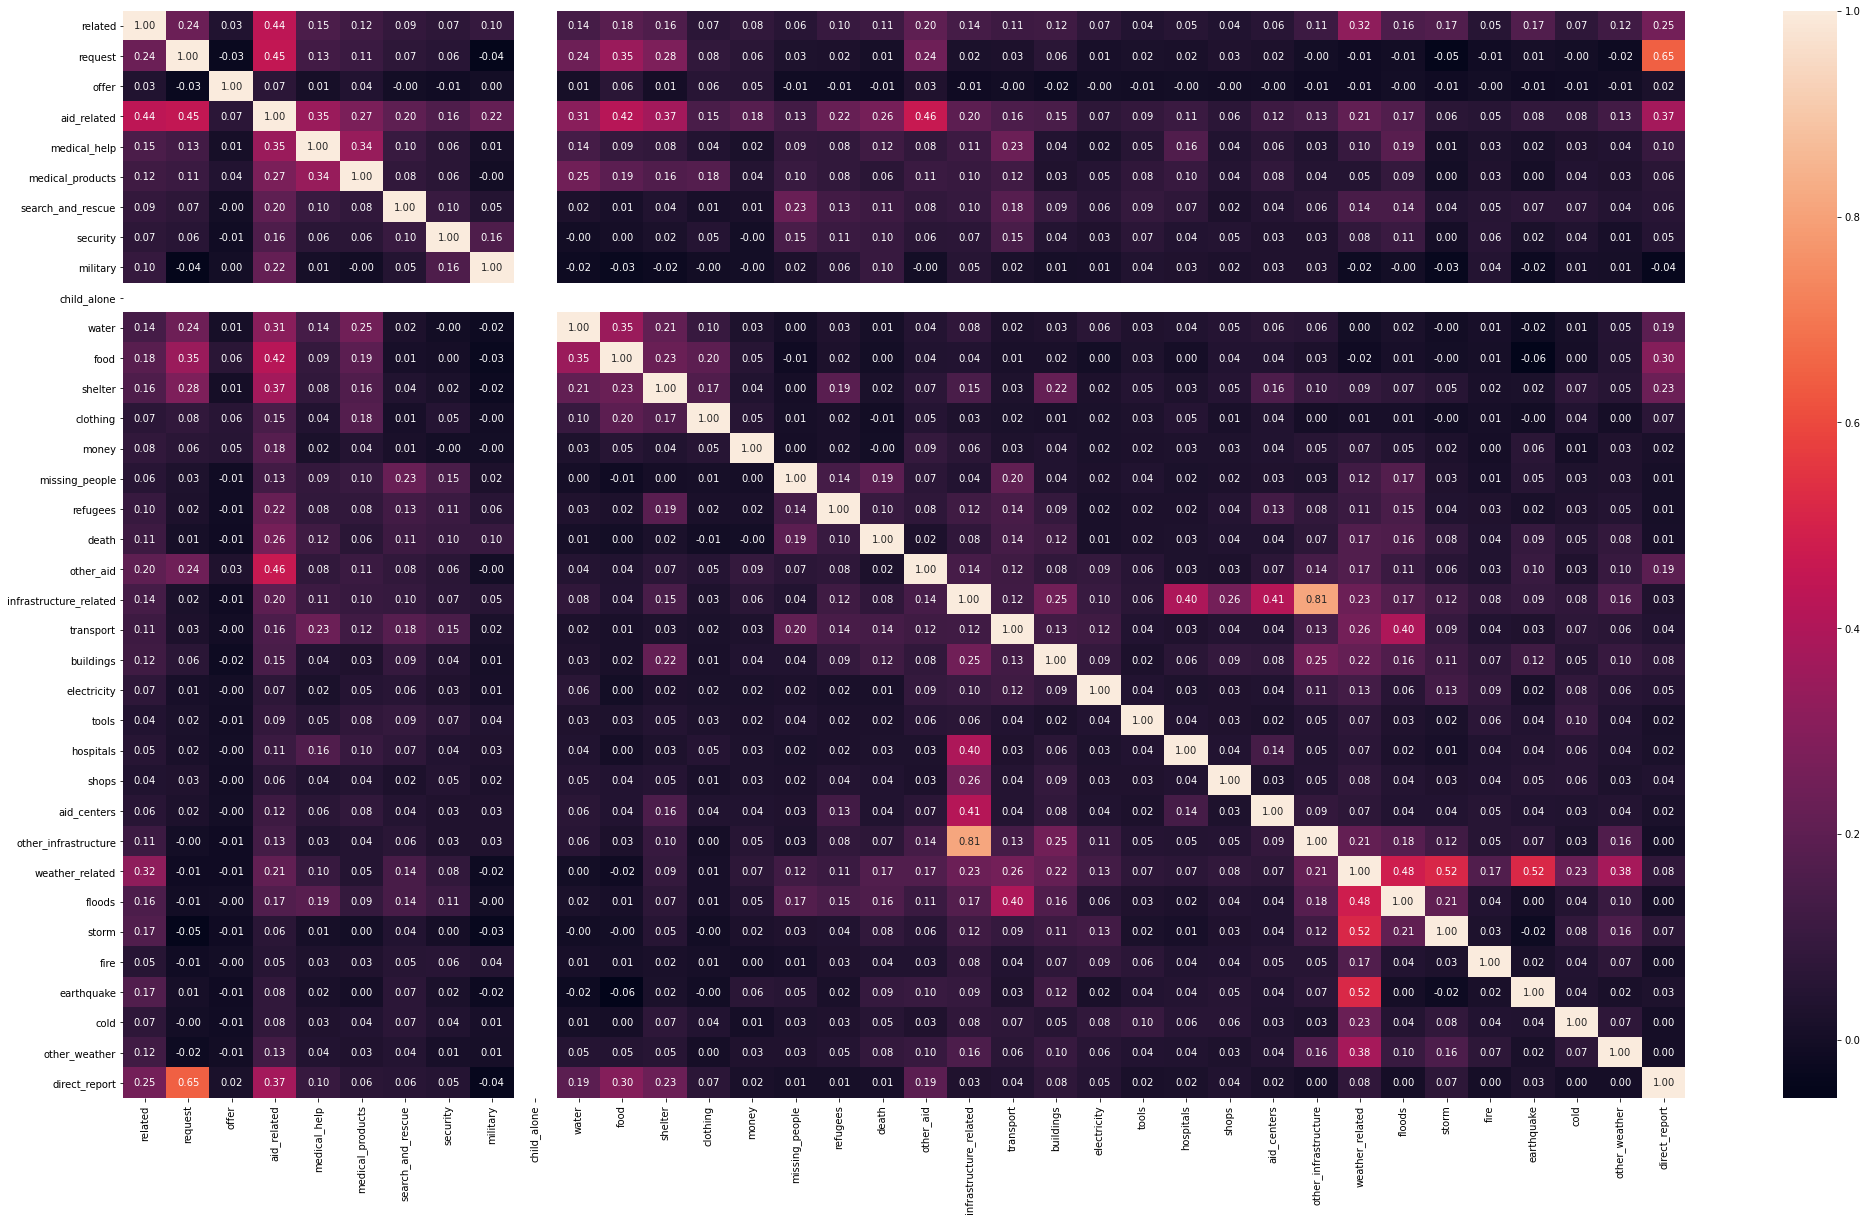

In [224]:
sns.heatmap(y.corr(), annot=True, fmt='.2f', ax = plt.figure(figsize = (35,20)).gca())

In [220]:
y['related']

0        1
1        1
2        1
3        1
4        1
        ..
26211    0
26212    0
26213    1
26214    1
26215    1
Name: related, Length: 26216, dtype: int64

In [198]:
print(y.iloc[:,0][0])

1


In [154]:
y.shape

(26216, 37)

In [62]:
X.unique()[:11]

array(['Weather update - a cold front from Cuba that could pass over Haiti',
       'Is the Hurricane over or is it not over',
       'Looking for someone but no name',
       'UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.',
       'says: west side of Haiti, rest of the country today and tonight',
       'Information about the National Palace-',
       'Storm at sacred heart of jesus',
       'Please, we need tents and water. We are in Silo, Thank you!',
       'I would like to receive the messages, thank you',
       'I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in Santo 15. ( an area in Croix-des-Bouquets )',
       "There's nothing to eat and water, we starving and thirsty."],
      dtype=object)

In [115]:
y.columns

Index(['genre', 'related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

### 2. Write a tokenization function to process your text data

In [45]:
from nltk.corpus import stopwords

def tokenize(text):
    '''
    '''
    en_stops = set(stopwords.words('english'))
    text = re.sub(r"[^a-zA-Z0-9]", " ", text).lower()
    sentence = word_tokenize(text)
    tokens = [WordNetLemmatizer().lemmatize(word) for word in sentence if word not in en_stops]
    return tokens

In [48]:
#tokenize('I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in Santo 15. ( an area in Croix-des-Bouquets )')

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [69]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ]))
    ])),
    ('clf', MultiOutputClassifier(RandomForestClassifier())) 
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [71]:
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x000002421B95BF70>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())]))])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [79]:
y_test_pred = pipeline.predict(X_test)

In [118]:
target_names = ['genre', 'related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']
for i in range(len(y_test.T)):
    print(target_names[i]+": "+classification_report(y_test.iloc[:,i], y_test_pred.T[i])+'\n') 
    

genre:               precision    recall  f1-score   support

      direct       0.90      0.96      0.92      2672
        news       0.96      0.94      0.95      3280
      social       0.97      0.82      0.89       602

    accuracy                           0.93      6554
   macro avg       0.94      0.90      0.92      6554
weighted avg       0.94      0.93      0.93      6554


related:               precision    recall  f1-score   support

           0       0.70      0.44      0.54      1450
           1       0.86      0.94      0.90      5059
           2       0.24      0.47      0.31        45

    accuracy                           0.83      6554
   macro avg       0.60      0.62      0.58      6554
weighted avg       0.82      0.83      0.81      6554


request:               precision    recall  f1-score   support

           0       0.90      0.98      0.94      5388
           1       0.87      0.51      0.64      1166

    accuracy                           0.90    

hospitals:               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6490
           1       0.00      0.00      0.00        64

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.98      0.99      0.99      6554


shops:               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6518
           1       0.00      0.00      0.00        36

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      6554


aid_centers:               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6482
           1       0.00      0.00      0.00        72

    accuracy                           0.99      6554
   macro avg       0.49      0.50      0.50      6554
weighted avg       0.98      0.99      0.

### 6. Improve your model
Use grid search to find better parameters. 

In [119]:
pipeline.get_params()

{'memory': None,
 'steps': [('features',
   FeatureUnion(transformer_list=[('text_pipeline',
                                   Pipeline(steps=[('vect',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x000002421B95BF70>)),
                                                   ('tfidf',
                                                    TfidfTransformer())]))])),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'features': FeatureUnion(transformer_list=[('text_pipeline',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(tokenizer=<function tokenize at 0x000002421B95BF70>)),
                                                 ('tfidf',
                                                  TfidfTransformer())]))]),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'features__n_jobs': None,
 'features__transformer_

In [141]:
parameters = {
        'features__text_pipeline__vect__max_df': (0.5, 1.0),
        'features__text_pipeline__vect__max_features': (None, 5000, 10000),
        'features__text_pipeline__tfidf__use_idf': (True, False),
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__min_samples_split': [2, 4]
    }

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x000002421B95BF70>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())]))])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__n_estimators': [50, 100, 200]})

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [152]:
y_test_pred = cv.predict(X_test)
target_names = ['genre', 'related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']
for i in range(len(y_test.T)):
    print(target_names[i]+": "+classification_report(y_test.iloc[:,i], y_test_pred.T[i])+'\n') 
    

genre:               precision    recall  f1-score   support

      direct       0.90      0.95      0.92      2672
        news       0.96      0.94      0.95      3280
      social       0.97      0.82      0.89       602

    accuracy                           0.93      6554
   macro avg       0.94      0.90      0.92      6554
weighted avg       0.93      0.93      0.93      6554


related:               precision    recall  f1-score   support

           0       0.71      0.44      0.54      1450
           1       0.86      0.94      0.90      5059
           2       0.25      0.51      0.34        45

    accuracy                           0.83      6554
   macro avg       0.61      0.63      0.59      6554
weighted avg       0.82      0.83      0.81      6554


request:               precision    recall  f1-score   support

           0       0.90      0.98      0.94      5388
           1       0.88      0.52      0.65      1166

    accuracy                           0.90    

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


offer:               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      6554


aid_related:               precision    recall  f1-score   support

           0       0.80      0.84      0.82      3778
           1       0.76      0.71      0.74      2776

    accuracy                           0.79      6554
   macro avg       0.78      0.78      0.78      6554
weighted avg       0.78      0.79      0.78      6554


medical_help:               precision    recall  f1-score   support

           0       0.92      1.00      0.96      6007
           1       0.72      0.09      0.16       547

    accuracy                           0.92      6554
   macro avg       0.82      0.54      0.56      6554
weighted avg       0.91      0.92     

other_infrastructure:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      6262
           1       0.25      0.01      0.01       292

    accuracy                           0.95      6554
   macro avg       0.60      0.50      0.50      6554
weighted avg       0.92      0.95      0.93      6554


weather_related:               precision    recall  f1-score   support

           0       0.90      0.95      0.92      4698
           1       0.85      0.73      0.79      1856

    accuracy                           0.89      6554
   macro avg       0.88      0.84      0.85      6554
weighted avg       0.89      0.89      0.88      6554


floods:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      6006
           1       0.91      0.52      0.66       548

    accuracy                           0.96      6554
   macro avg       0.93      0.76      0.82      6554
weighted avg       0.95  

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [151]:
#pickle.dump(pipeline, open('pipeline.pkl', 'wb'))
pickle.dump(cv, open('cv', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.